## **Train Pipeline**
This notebook will be used to train the CNN based network for the MNIST dataset.

In [1]:
import sys
sys.path.append("/home/jupyter-iroy2/advanced-neural-networks")

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from tqdm.notebook import tqdm

import advanced_neural_networks
from advanced_neural_networks.trainer.trainer import MNISTTrainer
from advanced_neural_networks.dataloader.mnist import MNISTDataset
from advanced_neural_networks.models.simple_convnet import SimpleConvNet
from advanced_neural_networks.models.lenet import LeNet
from advanced_neural_networks.models.feature_extractor import FeatureExtractor

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-8657ad57-c1e5-5b9e-91c8-492b2a0bd0ff"

2024-03-05 21:45:31.808325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 21:45:31.808362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 21:45:31.809107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 21:45:31.814059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 21:45:32.550226: W tensorflow/compiler/tf2

In [3]:
module_dir = advanced_neural_networks.__path__[0]
dataloader_path = os.path.join(module_dir, "dataloader")
dataset_config = os.path.join(dataloader_path, "mnist_config.yaml")
trainer_config = os.path.join(module_dir, "trainer", "trainer_config.yaml")

In [4]:
## load dataset
mnist_train = MNISTDataset(config = dataset_config,
                          location = "cloud",
                          train = True,
                          transforms = [],
                          data_type = "CIFAR10")

mnist_val = MNISTDataset(config = dataset_config,
                          location = "cloud",
                          train = False,
                          transforms = [],
                          data_type = "CIFAR10")


Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_example = mnist_train[0]

batch_img, batch_label = batch_example
print(f"Batch Img: {batch_img.shape}")
print(f"Batch Label: {batch_label.shape}")

Batch Img: torch.Size([3, 32, 32])
Batch Label: torch.Size([1, 10])


In [6]:
## initialize model, loss function and optimizer

batch_size = 64
learning_rate = 0.001
momentum = 0.9

model_params = {"input_shape": [batch_size, *batch_img.shape],
                 "n_conv_blocks": 3,
                 "out_channel_list": [16, 32, 64],
                 "kernel_size": 3,
                 "pool_size": 2,
                 "n_linear_layers": 2,
                 "n_neurons_list": [60, 10]}

optimizer_type = "Adam"
optimizer_params = {"optimizer_type": optimizer_type, "lr": learning_rate}  


In [7]:
## initialize trainer
model_trainer = MNISTTrainer(trainer_config, location = "cloud", data_type = "CIFAR10")
max_epochs = 20
model_trainer.max_epochs = max_epochs

Files already downloaded and verified


In [8]:
metrics_df, model = model_trainer.train(model_params,
                                 optimizer_params,
                                 mnist_train,
                                 mnist_val)

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

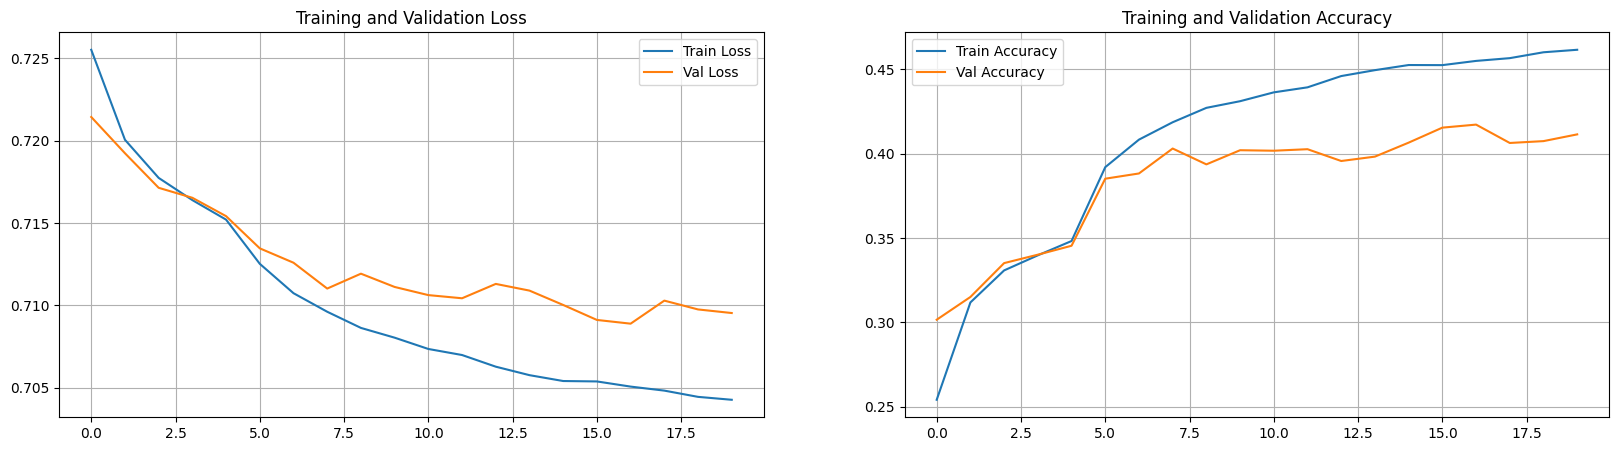

In [9]:
plt.figure(figsize = (20, 5))

ax = plt.subplot(1, 2, 1)
ax.set_title("Training and Validation Loss")
ax.plot(np.arange(max_epochs), metrics_df["train_loss"], label = "Train Loss")
ax.plot(np.arange(max_epochs), metrics_df["val_loss"], label = "Val Loss")
ax.grid()
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.set_title("Training and Validation Accuracy")
ax.plot(np.arange(max_epochs), metrics_df["train_acc"], label = "Train Accuracy")
ax.plot(np.arange(max_epochs), metrics_df["val_acc"], label = "Val Accuracy")
ax.grid()
ax.legend()
plt.show()

## **Feature Extraction**

In [29]:
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data


def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [12]:
layer_names = [layer_id for layer_id in model._modules]
layer_names

['conv_layers', 'flatten', 'linear_layers', 'softmax']

In [21]:
feature_extractor = FeatureExtractor(model, layers = ["flatten", "linear_layers"])
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = False)
device = "cuda"
flattened_features = []
labels = []
for itr, batch in enumerate(train_dataloader):

    img, label = batch
    img, label = img.to(device), label.to(device)
    features = feature_extractor(img)
    flattened_features.append(features["flatten"].detach().cpu().numpy()) 
    labels.append(label.detach().cpu().numpy())

    if itr == 10:
        break

In [25]:
flattened_features = np.array(flattened_features)
flattened_features = flattened_features.reshape(len(flattened_features) * batch_size, -1)

In [27]:
labels = np.array(labels)
labels = labels.reshape(len(labels) * batch_size, -1)

In [30]:
tsne_rep = get_tsne(flattened_features)

In [35]:
class_labels = np.argmax(labels, axis=1)
class_labels.shape

(704,)

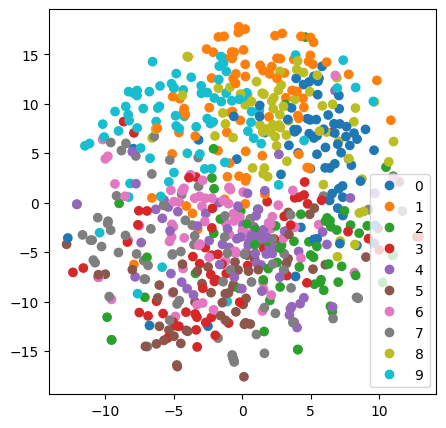

In [36]:
plot_representations(tsne_rep, class_labels)